Let's use **Box-Jenkins** methodology to fit an $ARIMA(p,d,q)$ model to daily BTC prices, evaluating last 5 years of data:

> 1) Model Identification
> 2) Model Estimation
> 3) Model Diagnostics

Before we start, let's download and clean our data to get it ready for analytics:

In [113]:
# Libraries
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey Fuller test for stationarity

In [114]:
# Download and clean data
end = datetime.datetime.now()
timedelta = datetime.timedelta(5 * 365)  # last 3 years
start = end - timedelta
df_btc = pd.DataFrame(yf.download("BTC-USD", start, end)["Adj Close"])
df_btc.columns = ["BTC"]

# Calculate 2 order percent changes
df_btc["pct_1"] = df_btc["BTC"].pct_change()
df_btc["pct_2"] = df_btc["pct_1"].pct_change()
df_btc = df_btc.dropna()  # remove NaN values
print(df_btc)
print("NaN count =", df_btc.isna().sum())

[*********************100%%**********************]  1 of 1 completed
                     BTC     pct_1     pct_2
Date                                        
2018-12-11   3424.588135 -0.022288 -0.278043
2018-12-12   3486.950195  0.018210 -1.817029
2018-12-13   3313.677246 -0.049692 -3.728808
2018-12-14   3242.484863 -0.021484 -0.567647
2018-12-15   3236.761719 -0.001765 -0.917845
...                  ...       ...       ...
2023-12-04  41980.097656  0.050070  2.936929
2023-12-05  44080.648438  0.050037 -0.000657
2023-12-06  43746.445312 -0.007582 -1.151521
2023-12-07  43292.664062 -0.010373  0.368174
2023-12-08  43685.648438  0.009077 -1.875099

[1824 rows x 3 columns]
NaN count = BTC      0
pct_1    0
pct_2    0
dtype: int64


________

## 1) Model Identification


First we need to check for stationarity using **Augmented Dickey Fuller** test on columns:

In [115]:
def testADF(dataframe, collist):
    """Checks for stationarity using Augmented Dickey Fuller test using statsmodels,
    returns p values for the values in columns in collist

    Args:
        dataframe (pandas DataFrame): a DataFrame where columns are time series values and dates are indexes
        collist (list of strings): A list of column names
    
    Returns:
        a dict of ADF p values corresponding to the columns of the dataframe, keys are column names
    """
    pvalues = {}
    for col in collist:
        pvalues[col] = adfuller(dataframe.loc[:, col])[1]
    return pvalues

testADF(df_btc, ["BTC", "pct_1"])  # first order difference is stationary

{'BTC': 0.5374807632205932, 'pct_1': 0.0}

Because $p < 0.05$ for first order **percent** difference time series, we can safely say that $\nabla^{pct} X_t$ is a stationary time series but let's plot the first order difference just to be sure:

[Text(0.5, 1.0, 'First order percent difference time series of BTC prices'),
 Text(0, 0.5, '$\\nabla^{pct} X_t$'),
 Text(0.5, 0, 'Dates')]

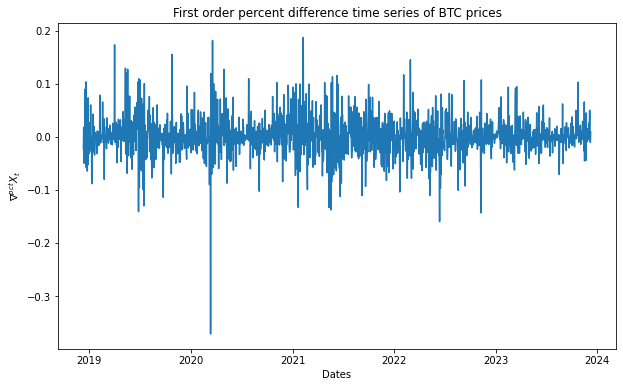

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_btc.loc[:, "pct_1"])
ax.set(title="First order percent difference time series of BTC prices", ylabel=r"$\nabla^{pct} X_t$", xlabel="Dates")

Indeed, visually, our first order percent difference time series looks like stationary. Then we can safely pick our value $d=1$ in our ARIMA(p, d, q) model. Then, look at ACF and PACF plots to think about $p$ and $q$ values.

Obtain the correlogram and fit an ARMA(p, q) model to the difference where,

> $p$ is the cut-off point to the **PACF**
 
> $q$ is the cut-off point to the **ACF**. 
  
This is an ARIMA(p,1,q) model to the original series.

**For an AR(p) process:** The PACF theoretically cuts off after lag p, because the partial correlation accounts for the effect of intervening lags.

**For an MA(q) process:** The ACF theoretically cuts off after lag q, as future values are not correlated with the error terms beyond lag q.

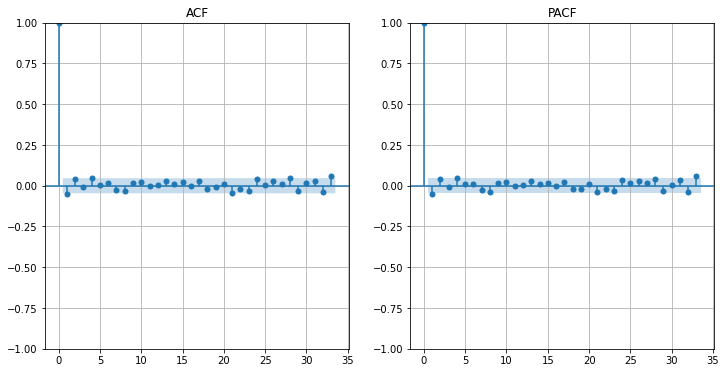

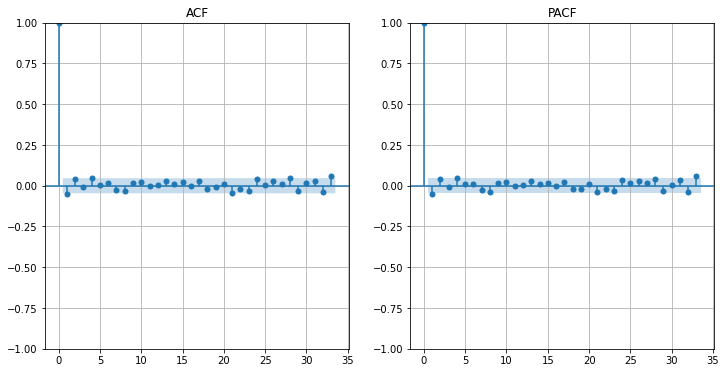

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].grid()
axs[1].grid()
plot_acf(df_btc.loc[:, "pct_1"], title="ACF", ax=axs[0])
plot_pacf(df_btc.loc[:, "pct_1"], title="PACF", ax=axs[1])
# plot_acf(df_btc.loc[:, "BTC"], title="ACF", ax=axs[0])
# plot_pacf(df_btc.loc[:, "BTC"], title="PACF", ax=axs[1])

It seems we cannot visiually pick a model because there are no significant correlations, ACF or PACF. Let's use an auto arima function to find good ARIMA model parameters:

In [118]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Efficient ARIMA model Selection
mod_can_auto = auto_arima(
    df_btc.loc[:, "pct_1"].dropna(),  # stepwise=False,
    start_p=0,
    start_d=0,
    start_q=0,
    max_p=3,
    max_d=3,
    max_q=3,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7023.293, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7025.881, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7025.509, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7027.168, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7025.172, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7025.185, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7027.563, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7024.825, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-7026.824, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7025.255, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7031.976, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7030.102, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7030.494, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7029.404, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0

The auto arima function tells us the BTC percent returns are most likely modeled as an ARIMA(1, 0, 1).

## 2) Model Estimation

Then, let's fit an ARIMA(0, 0, 0) model to **BTC percent returns**.

In [119]:
btc_arima_101 = ARIMA(df_btc["pct_1"], order=(1, 0, 1), trend="n").fit()
btc_arima_101.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  pct_1   No. Observations:                 1824
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3516.782
Date:                Fri, 08 Dec 2023   AIC                          -7027.563
Time:                        17:24:36   BIC                          -7011.037
Sample:                    12-11-2018   HQIC                         -7021.467
                         - 12-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5574      0.207     -2.692      0.007      -0.963      -0.152
ma.L1          0.5020      0.215      2.335      0.020       0.081       0.923
sigma2         0.0012   1.71e-05     72.441      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7572.73
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This seems like a decent model. Let's run diagnostics:

## 3) Model Diagnostics

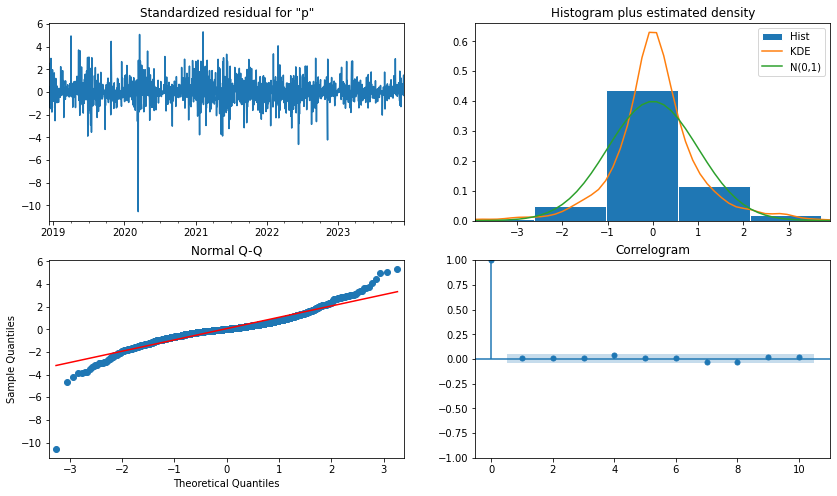

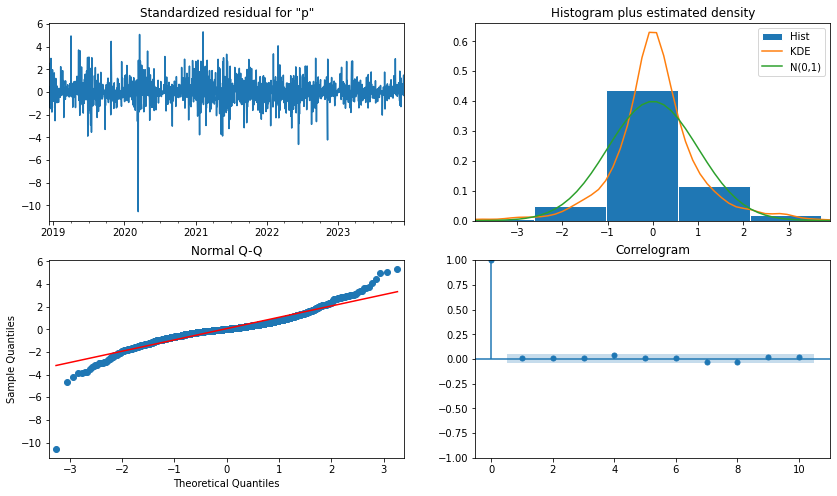

In [120]:
# Diagnostic Report for ARIMA(0,1,0) model on BTC price
btc_arima_101.plot_diagnostics(figsize=(14, 8))

No autocorrelation between residuals, that is a good sign that our model does not have systematic error terms.

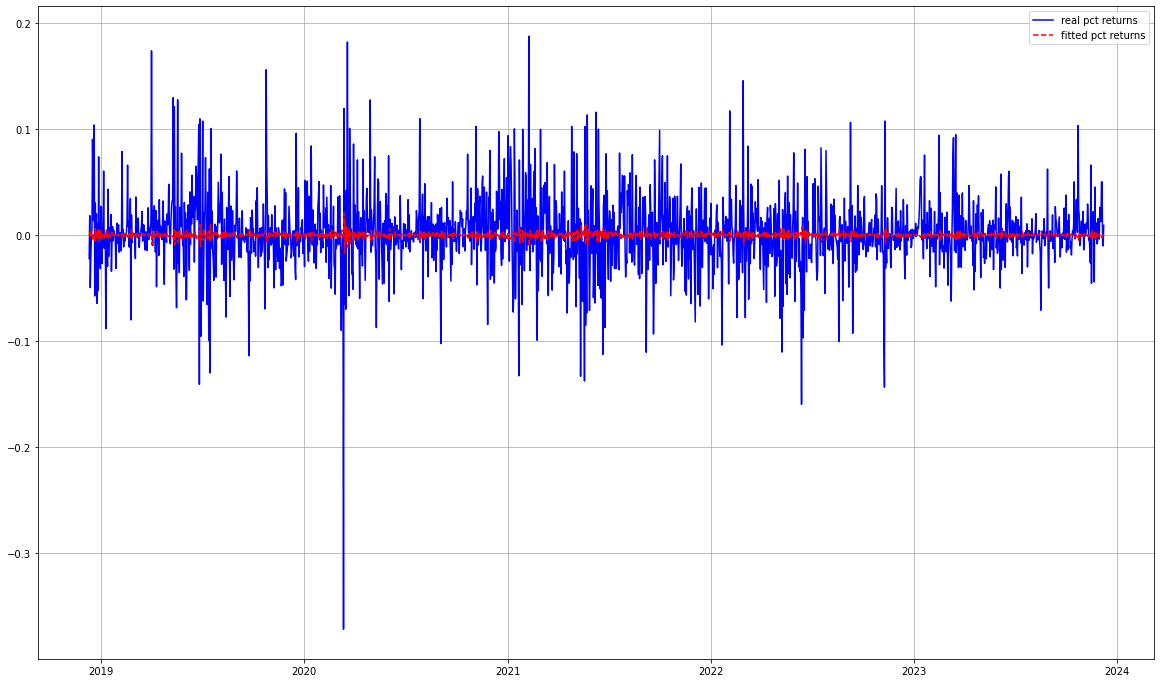

In [121]:
plt.figure(figsize=(20, 12))
plt.plot(df_btc["pct_1"], "b", label="real pct returns")
plt.plot(btc_arima_101.fittedvalues, "r--", label="fitted pct returns")
plt.grid()
plt.legend()

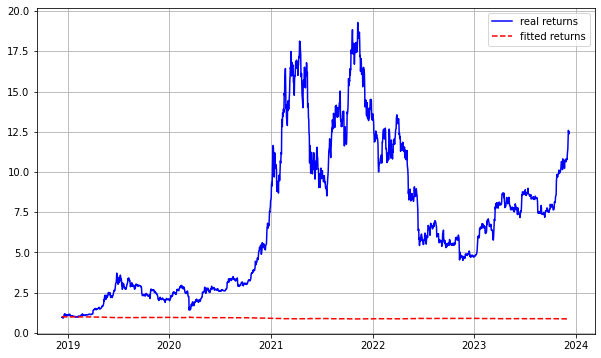

In [122]:
# Plot cumulative real vs fitted percent returns
df_btc["real_pct_returns"] = (1 + df_btc["pct_1"]).cumprod()
df_btc["fitted_pct_returns"] = (1 + btc_arima_101.fittedvalues).cumprod()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_btc["real_pct_returns"], "b-", label="real returns")
ax.plot(df_btc["fitted_pct_returns"], "r--", label="fitted returns")
ax.grid()
ax.legend()

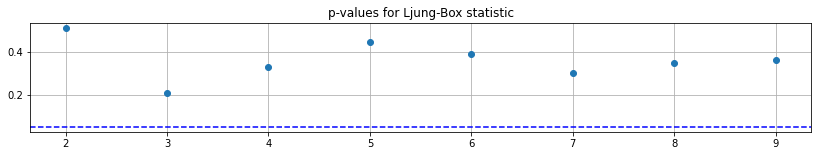

In [123]:
# Ljung-Box test for no serial correlation of standardized residuals
lb_test = btc_arima_101.test_serial_correlation(
    method="ljungbox", df_adjust=True, lags=None
)

# plot Ljung-Box test p-values and 0.05 significance line
plt.figure(figsize=(14, 2))
plt.plot(lb_test[0][1], linestyle="", marker="o")
plt.axhline(y=0.05, color="blue", linestyle="--")
plt.title("p-values for Ljung-Box statistic")
plt.grid()
plt.show()

It is proven from the Ljung-Box test that the residuals show no correlation and can claim residuals are independent.